In [1]:
import sys
import os
import numpy as np
import torch
import pandas as pd
import csv
import matplotlib.pyplot as plt
from scipy.stats import binom

In [2]:
# custom imports
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../..")))

from src.utils import load_config
import src.graphs_generation as graphs_gen

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

c:\Users\danie\Desktop\Virtual Envs\ML\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Common functions

Functions adapted from:
`\HUPLACLIP-NNs\scripts\visualizations\degree_distribution.ipynb`

In [3]:
def p_correction(p_nodes, graph_size, clique_size):
    '''Returns the value of the corrected p-value in the graph with clique ("p_reduce" case) '''
    p_corrected = (
        p_nodes * graph_size * (graph_size - 1)
        - clique_size * (clique_size - 1)
    ) / ((graph_size - clique_size) * (graph_size + clique_size - 1))
    return p_corrected

# P(d|C=0)
def p_noclique(degree_arr, graph_size):
    ''' 
    For an array of degree values (degree_arr: ndarray of shape [N_graphs, 1, graph_size]), returns the probability that (in a graph WITHOUT the clique) a node has exactly that degree.    
    Returns: ndarray of probabilities, same shape as degree_arr
    NOTE: already log-transformed, to be used directly in decision variable computation.
    '''
    return binom.logpmf(degree_arr, 
                     graph_size-1, 
                     0.5    # "p_reduce" correction only acts on graph with clique
                     )

def degree_distribution_noclique(degree_arr, graph_size):
    '''
    Uses p_noclique to obtain the overall probability that (in a graph WITHOUT the clique) a node has exactly that degree.
    '''
    return p_noclique(degree_arr, graph_size)

# P(d|C=1)
def p_ingroup(degree_arr, graph_size, clique_size, p_corrected):
    ''' 
    For an array of degree values (degree_arr: ndarray of shape [N_graphs, 1, graph_size]), returns the probability that (in a graph WITH the clique) a node INSIDE the clique has exactly that degree.    
    Returns: ndarray of probabilities, same shape as degree_arr
    '''
    return binom.pmf(degree_arr - (clique_size-1),  # number of non-clique connections
                     graph_size - clique_size,      # number of possible non-clique nodes
                     p_corrected
                     )

def p_outgroup(degree_arr, graph_size, clique_size, p_corrected):
    ''' 
    For an array of degree values (degree_arr: ndarray of shape [N_graphs, 1, graph_size]), returns the probability that (in a graph WITH the clique) a node OUTSIDE the clique has exactly that degree.    
    Returns: ndarray of probabilities, same shape as degree_arr
    '''
    return binom.pmf(degree_arr, 
                     graph_size-1, 
                     p_corrected
                     )

def degree_distribution_clique(degree_arr, graph_size, clique_size, p_corrected):
    '''Combines p_outgroup and p_ingroup (single mixture) to obtain the overall probability that (in a graph WITH the clique) a node has exactly that degree'''
    return clique_size/graph_size * p_ingroup(degree_arr, graph_size, clique_size, p_corrected) + (1-clique_size/graph_size) * p_outgroup(degree_arr, graph_size, clique_size, p_corrected)    

# Ideal observers

## K known

### Definitions

Designed at SISSA on 06/08/2025

![Alt text](../../scripts/Ideal-observer_performance/whiteboard_images/ideal-observer_06-08-2025_k-known.png)

In [102]:
def ideal_observer_k_known(graphs_batch, graph_size, clique_size, p_corrected):
  # for each graph in the batch, compute the degree of each node and store in a 1-D array
  degrees = np.array(torch.sum(graphs_batch, dim=2))  # shape: (batch_size, 1, graph_size)
  # computing decision variable:
  decision_variable = np.sum(np.log(degree_distribution_clique(degrees, graph_size, clique_size, p_corrected)) - degree_distribution_noclique(degrees, graph_size), 2)  # shape: (batch_size, 1)
  # Convert values > 0 to 1, values <= 0 to 0
  hard_output = (decision_variable > 0).astype(int)
  return hard_output.squeeze()

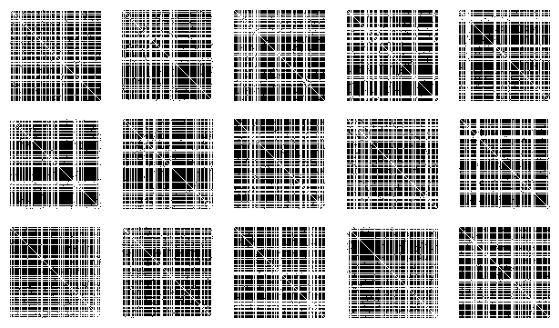

Fraction of correct responses:
1.0


In [110]:
# test of model on a very easy instance:
# visualizing input for graph of 1000 nodes and clique of 300, "p_reduce"
graphs_with_clique = graphs_gen.generate_batch(15, 100, np.repeat([70],15), "p_reduce", False, p_clique=1)
# Show 15 graphs
fig, axes = plt.subplots(3, 5, figsize=(7, 4))
for i in range(15):
    row = i // 5
    col = i % 5
    axes[row, col].imshow(np.squeeze(graphs_with_clique[0][i]), cmap='gray_r')
    axes[row, col].axis('off')
plt.show()
# testing ideal observer on this graph:
p_corrected = p_correction(0.5, 100, 70)
decision_variable = ideal_observer_k_known(graphs_with_clique[0], 100, 70, p_corrected)
print("Fraction of correct responses:")
print(np.sum(decision_variable == graphs_with_clique[1]) / 15)

### Testing:

In [111]:
# read configuration file:
config = load_config(
    os.path.join("Ideal-observer_test_config.yml")
)
    
# looping over the different graph sizes in the experiment:
for graph_size in config["graph_size_values"]:

    # Create empty dictionaries for storing testing results:
    fraction_correct_results = {}  # Fraction correct for each clique size
    metrics_results = {}  # Metrics dictionary

    # Calculate max clique size (proportion of graph size):
    max_clique_size = int(
        config["testing_parameters"]["max_clique_size_proportion_test"] * graph_size
    )

    # Calculate array of clique sizes for all test curriculum
    # NOTE: if max clique size is smaller than the the number of test levels, use max clique size as the number of test levels
    clique_sizes = np.linspace(
        max_clique_size,
        1,
        num=min(max_clique_size, config["testing_parameters"]["clique_testing_levels"]),
    ).astype(int)
    
    # Metrics initialization
    TP, FP, TN, FN = 0, 0, 0, 0  

    # Loop for decreasing clique sizes
    for current_clique_size in clique_sizes:

        # Computing value of p_corrected for current N/K combination
        p_corrected = p_correction(0.5, graph_size, current_clique_size)

        # Initialize fraction correct list, updated at each test iteration
        fraction_correct_list = []

        # Loop for testing iterations:
        for test_iter in range(config["testing_parameters"]["test_iterations"]):

            # Generate clique size value of each graph in the current batch
            clique_size_array_test = graphs_gen.generate_batch_clique_sizes(
                np.array([current_clique_size]),
                config["testing_parameters"]["num_test"],
            )

            # Generate validation graphs
            test = graphs_gen.generate_batch(
                config["testing_parameters"]["num_test"],
                graph_size,
                clique_size_array_test,
                config["p_correction_type"],
                False,
            )
                        
            hard_output = ideal_observer_k_known(test[0], graph_size, current_clique_size, p_corrected)
            test_labels = np.array(test[1]) # convert list to numpy array
            # print(hard_output.shape, test_labels.shape)   # DEBUGGING

            # transforming hard_output and test_labels to torch tensors:
            hard_output = torch.tensor(hard_output, dtype=torch.float32)
            test_labels = torch.tensor(test[1], dtype=torch.float32)
            
            # Compute metrics
            TP += ((hard_output == 1) & (test_labels == 1)).sum().item()
            FP += ((hard_output == 1) & (test_labels == 0)).sum().item()
            TN += ((hard_output == 0) & (test_labels == 0)).sum().item()
            FN += ((hard_output == 0) & (test_labels == 1)).sum().item()

            # updating fraction correct list with the accuracy of the current test iteration:
            fraction_correct_list.append(
                (hard_output == test_labels).sum().item()
                / (1.0 * config["testing_parameters"]["num_test"])
            )

        # Updating dictionary after all test iterations for current clique size have been completed:
        fraction_correct_results[current_clique_size] = round(
            sum(fraction_correct_list) / len(fraction_correct_list), 2
        )

        # Printing the size of the clique just tested and the corresponding test accuracy:
        print(
            f"||| Completed testing for clique = {current_clique_size}. "
            f"Average fraction correct = {fraction_correct_results[current_clique_size]}"
        )
        print("|||===========================================================")

    # - notify completion of testing:
    print(f"| Finished testing Ideal observer at N = {graph_size}.")

    # Computing metrics:
    precision = TP / (TP + FP + 1e-10)
    recall = TP / (TP + FN + 1e-10)
    F1 = 2 * (precision * recall) / (precision + recall + 1e-10)
    # AUC - ROC cannot be calculated (no soft outputs)
    # num_params has no meaning
    metrics_results = {
        "TP": TP,
        "FP": FP,
        "TN": TN,
        "FN": FN,
        "precision": precision,
        "recall": recall,
        "F1": F1,
        "AUC_ROC": np.nan,
        "total_params": np.nan,
    }

    # Saving accuracy results in .csv file:
    # - defining file name and path:
    file_path = os.path.join(
        os.getcwd(), "results", "ideal-observer-k-known", f"Ideal-observer-k-known_N{graph_size}_fraction_correct.csv"
    )
    # - saving the dictionary as a .csv file:
    with open(file_path, "w") as file:
        writer = csv.writer(file)
        writer.writerow(["clique size", "fraction correct"])  # Add column labels
        for key, value in fraction_correct_results.items():
            writer.writerow([key, value])
    # Saving metrics results in .csv file:
    # - defining file name and path:
    file_path = os.path.join(
        os.getcwd(), "results", "ideal-observer-k-known", f"Ideal-observer-k-known_N{graph_size}_metrics.csv"
    )
    # - saving the dictionary as a .csv file:
    pd.DataFrame([metrics_results]).to_csv(file_path, index=False)

    print(f"- Ideal observer Results saved successfully for N = {graph_size}.")

Configuration file loaded successfully.
||| Completed testing for clique = 70. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 69. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 68. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 67. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 66. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 65. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for clique = 64. Average fraction correct = 1.0
|||===========================================================
||| Completed testing for cli

## K not known

### Definitions

Designed at SISSA on 08/08/2025

![Alt text](../../scripts/Ideal-observer_performance/whiteboard_images/ideal-observer_08-08-2025_k-not-known.jpg)

In [78]:
def ideal_observer_k_not_known(graphs_batch, graph_size, clique_size_values, p_corrected_values):
    # NOTE: "clique_size_values" and "p_corrected_values" are arrays of the possible K values and the corresponding p_corrected values
    batch_size = len(graphs_batch)
    n_clique_size_values = len(clique_size_values)
    # for each graph in the batch, compute the degree of each node and store in a 1-D array
    degrees = np.array(torch.sum(graphs_batch, dim=2))  # shape: (batch_size, 1, graph_size)
    # broadcasting degrees so that they can be used in formula for different clique size values
    degrees_broadcast = np.broadcast_to(degrees, (batch_size, n_clique_size_values, graph_size)) # shape: (batch_size, n_clique_size_values, graph_size)
    # reshaping clique size values so that they can be broadcasted
    clique_size_values_broadcast = np.reshape(clique_size_values, (1, n_clique_size_values, 1))  # shape: (1, n_clique_size_values, 1)  
    # reshaping p_corrected so that it can be broadcasted
    p_corrected_broadcast = np.reshape(p_corrected_values, (1, n_clique_size_values, 1))  # shape: (1, n_clique_size_values, 1)  
    
    # FIRST VERSION (-inf issue at large graph_size values)
    # Compute degree distribution for all graphs and all clique sizes ("np.prod" is over graph_size dimension; "np.sum" is over n_clique_size_values dimension)
    # p_clique = np.log(
    #             (np.sum(
    #                 np.prod(degree_distribution_clique(degrees_broadcast, graph_size, clique_size_values_broadcast, p_corrected_broadcast),
    #                 axis = 2),
    #             axis = 1))
    #             / n_clique_size_values) # final shape: (batch_size, 1, 1)     
    
    # UPDATED VERSION (with logsumexp trick to avoid -inf issue)
    # Compute log-probabilities for each graph in the batch (1st dimension) and all clique sizes (2nd dimension)
    log_probs = np.sum(
        np.log(degree_distribution_clique(
            degrees_broadcast, graph_size, clique_size_values_broadcast, p_corrected_broadcast
        )),
        axis=2  # sum over nodes
    )  # shape: (batch_size, n_clique_size_values)
    # LogSumExp trick for numerical stability
    max_log_probs = np.max(log_probs, axis=1, keepdims=True)
    logsumexp = max_log_probs + np.log(np.sum(np.exp(log_probs - max_log_probs), axis=1, keepdims=True))
    # Normalize by the number of clique size values (uniform prior)
    p_clique = logsumexp - np.log(n_clique_size_values)  # shape: (batch_size, 1)
    
    # DEBUGGING
    print("Clique probabilities for all graphs:")
    print(p_clique.squeeze())
    print("No clique probabilities for all graphs:")
    print(np.sum(degree_distribution_noclique(degrees, graph_size), 2).squeeze())

    # computing decision variable
    decision_variable = p_clique.squeeze() - np.sum(degree_distribution_noclique(degrees, graph_size), 2).squeeze()
    # Convert values > 0 to 1, values <= 0 to 0
    hard_output = (decision_variable > 0).astype(int)

    print("Hard output:")
    print(hard_output)

    return hard_output.squeeze()

Clique size of:  15  in a graph of size:  100


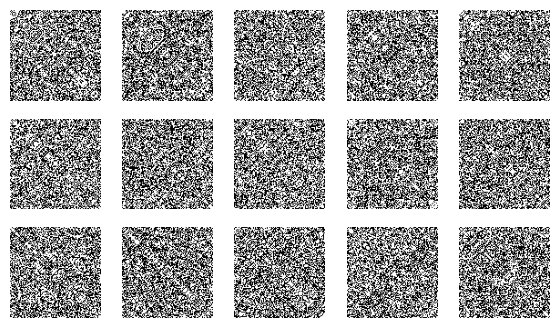

Clique size values:
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70]
p_corrected values:
[0.5        0.49989897 0.49969679 0.4993932  0.49898785 0.49848024
 0.49786975 0.49715563 0.496337   0.49541284 0.49438202 0.49324324
 0.49199507 0.49063593 0.48916409 0.48757764 0.48587453 0.48405253
 0.48210923 0.48004202 0.4778481  0.47552448 0.47306792 0.47047497
 0.46774194 0.46486486 0.46183953 0.45866142 0.4553257  0.45182724
 0.44816054 0.44431971 0.44029851 0.43609023 0.43168772 0.42708333
 0.42226891 0.4172357  0.41197434 0.40647482 0.40072639 0.39471753
 0.38843588 0.38186813 0.375      0.36781609 0.36029982 0.35243328
 0.34419714 0.33557047 0.32653061 0.31705298 0.30711086 0.29667519
 0.28571429 0.27419355 0.26207513 0.24931756 0.23587527 0.22169811
 0.20673077 0.19091206 0.17417417 0.15644172 0.13763066 0.11764706
 0.096385

In [79]:
# test of model on task instance
N_value = 100   #CHANGE THIS
clique_size_fraction = 0.15 # CHANGE THIS
print("Clique size of: ", int(clique_size_fraction*N_value), " in a graph of size: ", N_value)
# visualizing input for 15 graphs, "p_reduce"
graphs_with_clique = graphs_gen.generate_batch(15, N_value, np.repeat([int(clique_size_fraction*N_value)],15), "p_reduce", False, p_clique=1)
# Show 15 graphs
fig, axes = plt.subplots(3, 5, figsize=(7, 4))
for i in range(15):
    row = i // 5
    col = i % 5
    axes[row, col].imshow(np.squeeze(graphs_with_clique[0][i]), cmap='gray_r')
    axes[row, col].axis('off')
plt.show()
# testing ideal observer on this graph:
clique_size_values = np.arange(1, int(0.7*N_value) + 1, 1)  # clique sizes from 1 to N/2
p_corrected_values = p_correction(0.5, N_value, clique_size_values)

# DEBUGGING
print("Clique size values:")
print(clique_size_values)
print("p_corrected values:")
print(p_corrected_values)

decision_variable = ideal_observer_k_not_known(graphs_with_clique[0], N_value, clique_size_values, p_corrected_values)
print("Fraction of correct responses:")
print(np.sum(decision_variable == graphs_with_clique[1]) / 15)

### Testing

In [16]:
# read configuration file:
config = load_config(
    os.path.join("Ideal-observer_test_config.yml")
)
    
# looping over the different graph sizes in the experiment:
for graph_size in config["graph_size_values"]:

    # defining priors for clique sizes at current graph size:
    stat_limit = round(2 * np.log2(graph_size))
    clique_size_values = np.arange(stat_limit, (config["testing_parameters"]["max_clique_size_proportion_test"] * graph_size) + 1 )
    print("Clique size values for prior: ", clique_size_values)
    # defining corresponding p_corrected values:
    p_corrected_values = p_correction(0.5, graph_size, clique_size_values)
    print("P-corrected values for each clique size value: ", p_corrected_values)
    
    # Create empty dictionaries for storing testing results:
    fraction_correct_results = {}  # Fraction correct for each clique size
    metrics_results_list = []

    # Calculate max clique size for testing (proportion of graph size):
    max_clique_size = int(
        config["testing_parameters"]["max_clique_size_proportion_test"] * graph_size
    )

    # Calculate array of clique sizes for all test curriculum
    # NOTE: if max clique size is smaller than the the number of test levels, use max clique size as the number of test levels
    clique_sizes = np.linspace(
        max_clique_size,
        1,
        num=min(max_clique_size, config["testing_parameters"]["clique_testing_levels"]),
    ).astype(int)

    # Loop for decreasing clique sizes
    for current_clique_size in clique_sizes:

        # Metrics initialization (for each clique size)
        TP, FP, TN, FN = 0, 0, 0, 0  

        # Initialize fraction correct list, updated at each test iteration
        fraction_correct_list = []

        # Loop for testing iterations:
        for test_iter in range(config["testing_parameters"]["test_iterations"]):

            # Generate clique size value of each graph in the current batch
            clique_size_array_test = graphs_gen.generate_batch_clique_sizes(
                np.array([current_clique_size]),
                config["testing_parameters"]["num_test"],
            )

            # Generate validation graphs
            test = graphs_gen.generate_batch(
                config["testing_parameters"]["num_test"],
                graph_size,
                clique_size_array_test,
                config["p_correction_type"],
                False,
            )
                        
            hard_output = ideal_observer_k_not_known(test[0], graph_size, clique_size_values, p_corrected_values)
            test_labels = np.array(test[1]) # convert list to numpy array
            # print(hard_output.shape, test_labels.shape)   # DEBUGGING

            # transforming hard_output and test_labels to torch tensors:
            hard_output = torch.tensor(hard_output, dtype=torch.float32)
            test_labels = torch.tensor(test[1], dtype=torch.float32)
            
            # Compute metrics
            TP += ((hard_output == 1) & (test_labels == 1)).sum().item()
            FP += ((hard_output == 1) & (test_labels == 0)).sum().item()
            TN += ((hard_output == 0) & (test_labels == 0)).sum().item()
            FN += ((hard_output == 0) & (test_labels == 1)).sum().item()

            # updating fraction correct list with the accuracy of the current test iteration:
            fraction_correct_list.append(
                (hard_output == test_labels).sum().item()
                / (1.0 * config["testing_parameters"]["num_test"])
            )

        # Updating dictionary after all test iterations for current clique size have been completed:
        fraction_correct_results[current_clique_size] = round(
            sum(fraction_correct_list) / len(fraction_correct_list), 2
        )
        
        # Computing metrics:
        precision = TP / (TP + FP + 1e-10)
        recall = TP / (TP + FN + 1e-10)
        F1 = 2 * (precision * recall) / (precision + recall + 1e-10)
        # AUC - ROC cannot be calculated (no soft outputs)
        # num_params has no meaning
        metrics_results = {
            "N_value": graph_size,
            "clique_size": current_clique_size,
            "TP": TP,
            "FP": FP,
            "TN": TN,
            "FN": FN,
            "precision": precision,
            "recall": recall,
            "F1": F1,
            "AUC_ROC": np.nan,
            "total_params": np.nan,
        }
        metrics_results_list.append(metrics_results)

        # Printing the size of the clique just tested and the corresponding test accuracy:
        print(
            f"||| Completed testing for clique = {current_clique_size}. "
            f"Average fraction correct = {fraction_correct_results[current_clique_size]}"
        )
        print("|||===========================================================")


    # - notify completion of testing:
    print(f"| Finished testing Ideal observer at N = {graph_size}.")

    # Saving accuracy results in .csv file:
    # - defining file name and path:
    file_path = os.path.join(
        os.getcwd(), "results", "ideal-observer-k-not-known", f"Ideal-observer-k-not-known_N{graph_size}_fraction_correct.csv"
    )
    # - saving the dictionary as a .csv file:
    with open(file_path, "w") as file:
        writer = csv.writer(file)
        writer.writerow(["clique size", "fraction correct"])  # Add column labels
        for key, value in fraction_correct_results.items():
            writer.writerow([key, value])
    # Saving metrics results in .csv file:
    metrics_df = pd.DataFrame(metrics_results_list)    
    # - defining file name and path:
    file_path = os.path.join(
        os.getcwd(), "results", "ideal-observer-k-not-known", f"Ideal-observer-k-not-known_N{graph_size}_metrics.csv"
    )
    metrics_df.to_csv(file_path, index=False)

    print(f"- Ideal observer Results saved successfully for N = {graph_size}.")

Configuration file loaded successfully.
Clique size values for prior:  [13. 14. 15. 16. 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30.
 31. 32. 33. 34. 35. 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48.
 49. 50. 51. 52. 53. 54. 55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65. 66.
 67. 68. 69. 70.]
P-corrected values for each clique size value:  [0.49199507 0.49063593 0.48916409 0.48757764 0.48587453 0.48405253
 0.48210923 0.48004202 0.4778481  0.47552448 0.47306792 0.47047497
 0.46774194 0.46486486 0.46183953 0.45866142 0.4553257  0.45182724
 0.44816054 0.44431971 0.44029851 0.43609023 0.43168772 0.42708333
 0.42226891 0.4172357  0.41197434 0.40647482 0.40072639 0.39471753
 0.38843588 0.38186813 0.375      0.36781609 0.36029982 0.35243328
 0.34419714 0.33557047 0.32653061 0.31705298 0.30711086 0.29667519
 0.28571429 0.27419355 0.26207513 0.24931756 0.23587527 0.22169811
 0.20673077 0.19091206 0.17417417 0.15644172 0.13763066 0.11764706
 0.09638554 0.07372754 0.04953917 0.02366

C:\Users\danie\AppData\Local\Temp\ipykernel_11940\2497885552.py:14: RuntimeWarning: divide by zero encountered in log
  p_clique = np.log((np.sum(np.prod(degree_distribution_clique(


||| Completed testing for clique = 121. Average fraction correct = 0.99
|||===========================================================
||| Completed testing for clique = 120. Average fraction correct = 0.99
|||===========================================================
||| Completed testing for clique = 118. Average fraction correct = 0.96
|||===========================================================
||| Completed testing for clique = 117. Average fraction correct = 0.94
|||===========================================================
||| Completed testing for clique = 116. Average fraction correct = 0.93
|||===========================================================
||| Completed testing for clique = 114. Average fraction correct = 0.89
|||===========================================================
||| Completed testing for clique = 113. Average fraction correct = 0.81
|||===========================================================
||| Completed testing for clique = 111. Average fractio

### Metrics analysis

The hypothesis is that FP>FN  for small K values in the `ideal-observer-k-not-known` model.

Configuration file loaded successfully.


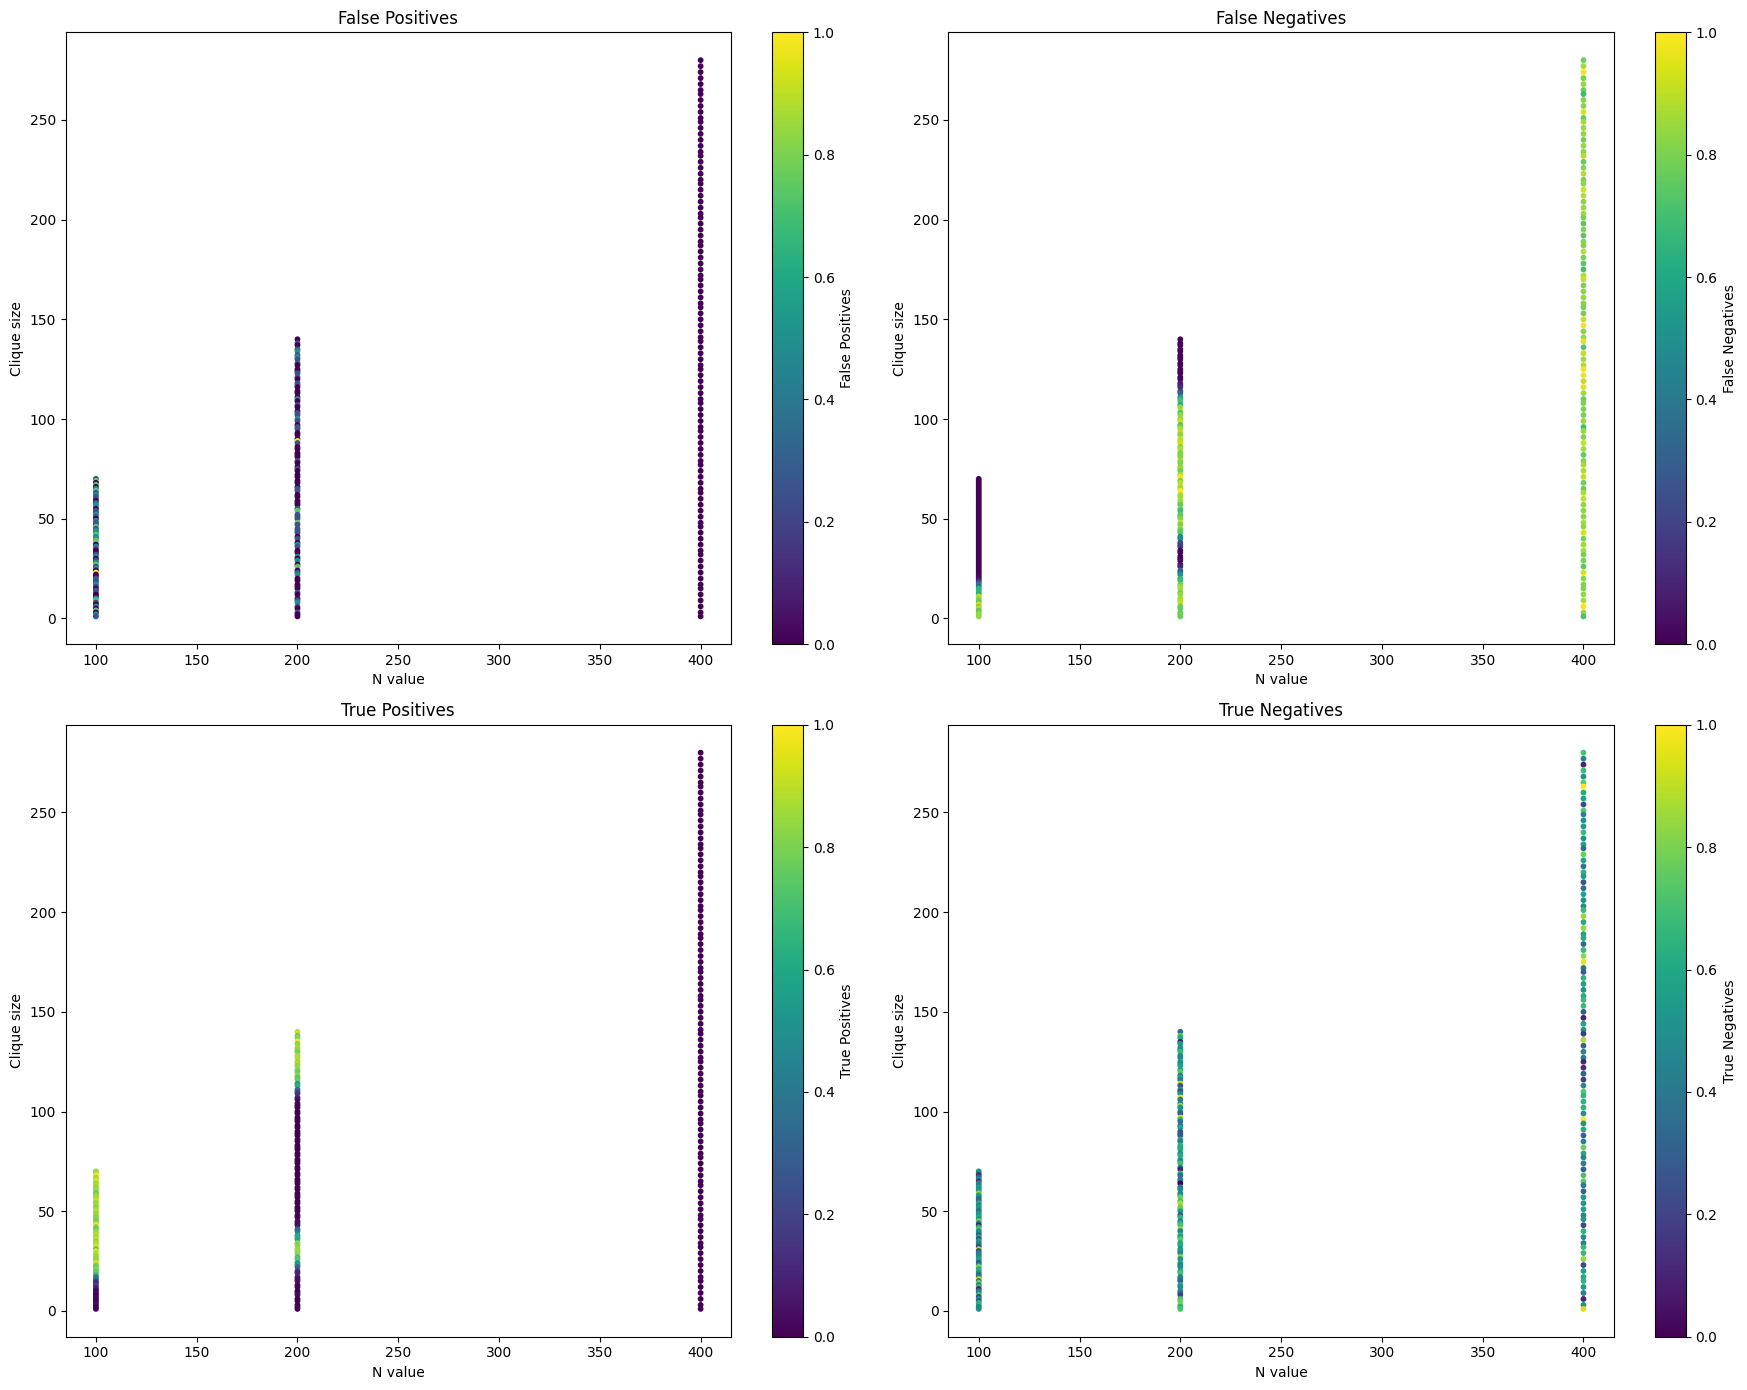

In [17]:
# read configuration file:
config = load_config(
    os.path.join("Ideal-observer_test_config.yml")
)
global_metric_df = pd.DataFrame()
    
# looping over the different graph sizes in the experiment:
for graph_size in [100, 200, 400]:
    file_path = os.path.join(os.getcwd(), "results", "ideal-observer-k-not-known", f"Ideal-observer-k-not-known_N{graph_size}_metrics.csv")
    metrics_df = pd.read_csv(file_path)
    global_metric_df = pd.concat([global_metric_df, metrics_df], ignore_index=True)

# normalizing metrics for better visualization:
cols_to_visualize = ['FP', 'FN', 'TP', 'TN']
global_metric_df[cols_to_visualize] = (global_metric_df[cols_to_visualize] - global_metric_df[cols_to_visualize].min()) / (global_metric_df[cols_to_visualize].max() - global_metric_df[cols_to_visualize].min())

# Visualizing FP, FN, TP, TN in a 2x2 grid with N value on the x-axis and clique size on the y-axis (color-coded):
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
metrics = ['FP', 'FN', 'TP', 'TN']
titles = ['False Positives', 'False Negatives', 'True Positives', 'True Negatives']

for idx, (metric, title) in enumerate(zip(metrics, titles)):
    ax = axes[idx // 2, idx % 2]
    im = ax.scatter(
        global_metric_df['N_value'],
        global_metric_df['clique_size'],
        c=global_metric_df[metric],
        cmap='viridis',
        s=10
    )
    ax.set_title(title)
    ax.set_xlabel('N value')
    ax.set_ylabel('Clique size')
    fig.colorbar(im, ax=ax, label=title)

plt.tight_layout()
plt.show()
